# Эксперименты с временным рядом стоимости алюминия с моделью Catboost

In [1]:
import numpy as np
import pandas as pd
#pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 60)
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


from darts import TimeSeries
from darts.metrics import mape, mae
from darts.models import CatBoostModel
#from darts.dataprocessing.transformers import Scaler

from datetime import timedelta
from copy import deepcopy
import random
#import torch
import optuna
from functools import partial
import datetime

In [2]:
def set_seed(seed: int = 42):
    """Set random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    #torch.manual_seed(seed)
    #torch.cuda.manual_seed_all(seed)
    
set_seed()

## Data

In [3]:
FORECAST_LEN = 4 # Длина прогноза
OUT_OF_TIME_DIM = 20 # Размер отложенной выборки

In [4]:
def set_seed(seed: int = 42):
    """Set random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    #torch.manual_seed(seed)
    #torch.cuda.manual_seed_all(seed)
    
set_seed()

In [5]:
price = pd.read_csv('original_price_al.csv', parse_dates=[0], dtype='float32')
print('Shape:', price.shape)

Shape: (295, 2)


In [6]:
df = pd.read_csv('../data/processed/prepared_dataset.csv', parse_dates=[0], dtype='float32')
print('Shape:', df.shape)

Shape: (290, 9)


In [7]:
df.columns.values[1:-1]

array(['value__sum_values_chalco_price_2_weeks',
       'value__index_mass_quantile__q_0.4_usa_inflation_value_26_weeks',
       'value__absolute_maximum_usd_to_rub_2_weeks',
       'value__time_reversal_asymmetry_statistic__lag_3_brazil_pmi_26_weeks',
       'value__fft_aggregated__aggtype_"centroid"_log10_norsk_hydro_volume_12_weeks',
       'value__c3__lag_3_norsk_hydro_price_12_weeks',
       'value__time_reversal_asymmetry_statistic__lag_2_export_australia_value_26_weeks'],
      dtype=object)

In [8]:
price = price.iloc[1:-4]

In [9]:
FORECAST_LEN = 4 # Длина прогноза
OUT_OF_TIME_DIM = 20 # Размер отложенной выборки

# Извлекаем временной ряд с ценами на alum
data_ts = TimeSeries.from_dataframe(price, time_col='date', value_cols='lme_price')
# Извлекаем коварианты
data_past_cov = TimeSeries.from_dataframe(df, time_col='date', value_cols=df.columns.values[1:-1])
# Возьмем срез данных для всего процесса развития модели ts & past_cov и out-of-time выборку
ts = data_ts[:-OUT_OF_TIME_DIM]
past_cov = data_past_cov[:-OUT_OF_TIME_DIM]
# Размер выборки out-of-time = 20 точек (то есть 20 недель)
# out-of-time выборка будет использована лишь в самом конце

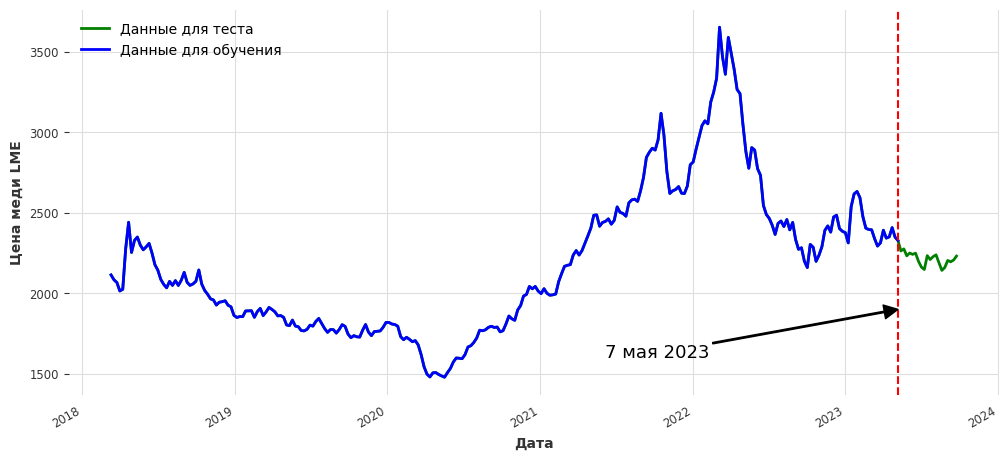

In [28]:
# Рисуем
# Рисуем
fig, ax = plt.subplots(figsize=(12, 5))
data_ts.plot(label="Данные для теста", color='g')
ts.plot(label="Данные для обучения", color='b')
l1 = ax.axvline(x=ts.end_time(), color='r', linestyle='--', linewidth=1.5)
ax.annotate('7 мая 2023', xy=(ts.end_time(), 1900), xytext=(ts.end_time() - datetime.timedelta(700), 1600),
            arrowprops=dict(facecolor='black', width=1, headwidth=10, headlength=10), fontsize = 13
            )
ax.set_ylabel('Цена меди LME');
ax.set_xlabel('Дата');
plt.savefig('pic1.png', dpi=400, format='png')

### Cross-validation

Так как backtest не работает, пропишем ручную версию  
В ручной версии подразумевается обучение модели с нуля на каждом шаге

In [21]:
def manual_backtest(model, ts, past_covariates, forecast_horizont=FORECAST_LEN, 
                    start_test=160, step = 30, save_curves=False,
                    rolling_window=False, window_size=None):
    '''
    Функция аналогична встроенной функции backtest
    '''
    shift = max(model.model_params["lags"], model.model_params["lags_past_covariates"])
    mape_metrics = list() # Список для метрик
    mae_metrics = list()
    prediction_curves = dict() # Список для последюущей визуализации кривых
    k=1
    # Скользящее или расширяющееся окно
    if rolling_window: 
        start_train = start_test - window_size
    else:
        start_train=0
    while True:
        print('Iter #', k)
        cur_train = ts[start_train : start_test]
        cur_test = ts[start_test - shift : start_test + int(forecast_horizont)]
        # Есть ли экзогенные признаки
        if past_covariates is not None:
            past_cov_train = past_covariates[start_train : start_test]
            past_cov_test = past_covariates[start_test - shift : start_test + int(forecast_horizont)]
            
            model1 = deepcopy(model)
            model1.fit(series=cur_train,
                       val_series=cur_test,
                       past_covariates=past_cov_train,
                       val_past_covariates=past_cov_test)
            cur_pred = model1.predict(int(forecast_horizont),
                                             series=cur_train,
                                             past_covariates=past_cov_train)
        # Если экзогенных признаков нет  
        else:
            model1 = deepcopy(model)
            model1.fit(series=cur_train_scaled)
            model1.fit(series=cur_train,
                      val_series=cur_test)
            cur_pred = model1.predict(int(forecast_horizont),
                                             series=cur_train)
        # Вычисляем метрику и добавляем в список
        mape_ = mape(cur_pred, cur_test, intersect=True)
        mae_ = mae(cur_pred, cur_test, intersect=True)
        mape_metrics.append(mape_)
        mae_metrics.append(mae_)
        # n_epochs.append(model1.epochs_trained)
        # При необходимости можно собирать информацию о количестве эпох обучения
        # Добавляем спрогнозированную кривую в набор кривых для последующей отрисовки
        prediction_curves['pred_'+str(k)]=cur_pred
        k+=1
        
        start_test+=step
        if rolling_window:
            start_train+=step
        if start_test + int(forecast_horizont) >= len(ts):
            break
            
    if save_curves==True:
        return mape_metrics, mae_metrics, prediction_curves
    else:
        return mape_metrics, mae_metrics

### Hyperparameter optimization (optuna)

In [13]:
def objective(trial, ts, past_cov, forecast_len = FORECAST_LEN):
    
    settings = {
        "lags" : trial.suggest_int("lags", 1, 50),
        "lags_past_covariates" : trial.suggest_int("lags_past_covariates", 1, 50),
        "iterations" : trial.suggest_int("iterations", low=20, high=1000, step=50),
        #"learning_rate" : trial.suggest_float("learning_rate", 1e-6, 0.1, log=True),
        "l2_leaf_reg" : trial.suggest_float("l2_leaf_reg", low=1.0, high=9.0, step=0.4),
        "depth" : trial.suggest_int("depth", 3, 8),
        "colsample_bylevel" : trial.suggest_float("colsample_bylevel", 0.1, 1.0),
        "min_data_in_leaf" : trial.suggest_int("min_data_in_leaf", 1, 200),
        "boosting_type" : trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type" : trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
    }

    if settings["bootstrap_type"] == "Bayesian":
        settings["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
     
    elif settings["bootstrap_type"] == "Bernoulli":
        settings["subsample"] = trial.suggest_float("subsample", 0.1, 1)
    
    settings_for_backtest = {
        "rolling_window" : trial.suggest_categorical("rolling_window", [True, False])
    }
    if settings_for_backtest["rolling_window"] == True:
        settings_for_backtest["window_size"] = trial.suggest_categorical("window_size", [52, 104])

    # build and train the RF model with these hyper-parameters:
    model = CatBoostModel(
        **settings,
        output_chunk_length=forecast_len,
        eval_metric = 'MAPE',
        task_type = "CPU",
        thread_count = 8,
        random_state=42
    )

    # Evaluate how good it is on the cross_validation for ts
    metrics, _ = manual_backtest(model, ts=ts, past_covariates=past_cov, **settings_for_backtest)
    mean_metric = np.mean(metrics)
    return mean_metric if mean_metric != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}", end='\n\n')
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}", end='\n\n')

def opt(ts, past_cov, iterations, forecast_len=17):
    opt_function=partial(objective, ts=ts, past_cov=past_cov)
    study = optuna.create_study(direction="minimize")
    study.optimize(opt_function, n_trials=iterations, callbacks=[print_callback])
    print("Number of finished trials: {}".format(len(study.trials)), end='\n\n')
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}", end='\n\n')
    for key, value in study.best_trial.params.items():
        print("  {}: {}".format(key, value))
    return study

In [14]:
def setup_params(best_params):
    if best_params['rolling_window']==True:
        settings_for_backtest = {
            'rolling_window':True,
            'window_size': best_params['window_size']
        }
        del best_params['rolling_window']
        del best_params['window_size']
    else:
        settings_for_backtest = {
            'rolling_window':False
        }
        del best_params['rolling_window']
    return best_params, settings_for_backtest

In [15]:
def build_and_fit_model(model_settings, backtest_settings, ts, past_cov, forecast_len=FORECAST_LEN):
    model = CatBoostModel(
        **model_settings,
        output_chunk_length=forecast_len,
        eval_metric = "MAPE",
        task_type = "CPU",
        thread_count = 16,
        random_state=42
    )

    shift = max(model.model_params["lags"], model.model_params["lags_past_covariates"])
    if backtest_settings["rolling_window"]==True:
        ts_train, ts_valid = ts[- backtest_settings["window_size"] - int(forecast_len) : - int(forecast_len)], ts[- int(forecast_len) - shift : ]
        past_cov_train, past_cov_valid = past_cov[- backtest_settings["window_size"] - int(forecast_len) : - int(forecast_len)], past_cov[- int(forecast_len) - shift : ]
    else:
        ts_train, ts_valid = ts[ : - int(forecast_len)], ts[- int(forecast_len) - shift : ]
        past_cov_train, past_cov_valid = past_cov[ : - int(forecast_len)], past_cov[- int(forecast_len) - shift : ]
    model.fit(series=ts_train,
              past_covariates=past_cov_train,
              val_series=ts_valid,
              val_past_covariates=past_cov_valid, verbose=False
             )
    return model

def evaluation_without_refitting(model, data_ts, candidates, out_of_time_dim=OUT_OF_TIME_DIM, forecast_len=FORECAST_LEN):
    '''
    Функция для построения прогноза и вычисления метрик на out-of-time выборке
    data_ts - датасет временного ряда
    data_past_cov - датасет ковариант
    model - модель
    out_of_time_dim - размер выборки out-of-time
    forecast_len - длина прогноза
    Scaler-ов нет, так как в градиентном бустинге не был использованы
    '''
    data_past_cov = TimeSeries.from_dataframe(df, time_col='date', value_cols=candidates)
    start_point = 0
    metrics = list()
    prediction_curves = {}
    step = 1
    shift = max(model.model_params["lags"], model.model_params["lags_past_covariates"])
    out_of_time_ts = data_ts[-(out_of_time_dim + shift):]
    out_of_time_past_cov = data_past_cov[-(out_of_time_dim + shift):]
    while True:
        cur_test_input = out_of_time_ts[start_point : start_point + shift]
        past_cov_test_input = out_of_time_past_cov[start_point : start_point + shift]
        prediction = model.predict(int(forecast_len), series=cur_test_input, past_covariates=past_cov_test_input)
        metric = mape(prediction, out_of_time_ts)
        metrics.append(metric)
        start_point+=step
        prediction_curves[start_point]=prediction
        if start_point + shift + int(forecast_len) > len(out_of_time_ts):
            break

    print("MAPE: {:.2f} +- {:.2f}".format(np.mean(metrics), np.std(metrics)))
    return prediction_curves, metrics

def evaluation_with_refitting(model_settings, backtest_settings, data_ts, data_past_cov, out_of_time_dim=OUT_OF_TIME_DIM, forecast_len=FORECAST_LEN):
    '''
    '''
    start_point = 0
    metrics = list()
    prediction_curves = {}
    step = 1
    shift = max(model_settings["lags"], model_settings["lags_past_covariates"])
    out_of_time_ts = data_ts[-(out_of_time_dim + shift):]
    out_of_time_past_cov = data_past_cov[-(out_of_time_dim + shift):]
    while True:
        ts = data_ts[:-out_of_time_dim+start_point]
        past_cov = data_past_cov[:-out_of_time_dim+start_point]
        model = build_and_fit_model(model_settings, backtest_settings, ts, past_cov)
        
        cur_test_input = out_of_time_ts[start_point : start_point + shift]
        past_cov_test_input = out_of_time_past_cov[start_point : start_point + shift]
        
        prediction = model.predict(int(forecast_len), series=cur_test_input, past_covariates=past_cov_test_input)
        metric = mape(prediction, out_of_time_ts)
        metrics.append(metric)
        start_point+=step
        prediction_curves[start_point]=prediction
        if start_point + shift + int(forecast_len) > len(out_of_time_ts):
            break

    print("MAPE: {:.2f} +- {:.2f}".format(np.mean(metrics), np.std(metrics)))
    return prediction_curves, metrics

## Building model

In [29]:
study = opt(ts=ts, past_cov=past_cov, iterations=50)

[I 2024-03-04 11:13:07,636] A new study created in memory with name: no-name-6595b25e-48e0-4857-8f5a-3f76bf209594
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 11:13:10,505] Trial 0 finished with value: 6.881318492600019 and parameters: {'lags': 4, 'lags_past_covariates': 12, 'iterations': 520, 'l2_leaf_reg': 3.4000000000000004, 'depth': 3, 'colsample_bylevel': 0.3150590433918078, 'min_data_in_leaf': 186, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.943749723976225, 'rolling_window': True, 'window_size': 52}. Best is trial 0 with value: 6.881318492600019.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 6.881318492600019, Current params: {'lags': 4, 'lags_past_covariates': 12, 'iterations': 520, 'l2_leaf_reg': 3.4000000000000004, 'depth': 3, 'colsample_bylevel': 0.3150590433918078, 'min_data_in_leaf': 186, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.943749723976225, 'rolling_window': True, 'window_size': 52}

Best value: 6.881318492600019, Best params: {'lags': 4, 'lags_past_covariates': 12, 'iterations': 520, 'l2_leaf_reg': 3.4000000000000004, 'depth': 3, 'colsample_bylevel': 0.3150590433918078, 'min_data_in_leaf': 186, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.943749723976225, 'rolling_window': True, 'window_size': 52}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 11:15:46,085] Trial 1 finished with value: 7.861143919496724 and parameters: {'lags': 16, 'lags_past_covariates': 33, 'iterations': 520, 'l2_leaf_reg': 1.0, 'depth': 5, 'colsample_bylevel': 0.7124371823578607, 'min_data_in_leaf': 129, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.25661507936324013, 'rolling_window': True, 'window_size': 104}. Best is trial 0 with value: 6.881318492600019.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 7.861143919496724, Current params: {'lags': 16, 'lags_past_covariates': 33, 'iterations': 520, 'l2_leaf_reg': 1.0, 'depth': 5, 'colsample_bylevel': 0.7124371823578607, 'min_data_in_leaf': 129, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.25661507936324013, 'rolling_window': True, 'window_size': 104}

Best value: 6.881318492600019, Best params: {'lags': 4, 'lags_past_covariates': 12, 'iterations': 520, 'l2_leaf_reg': 3.4000000000000004, 'depth': 3, 'colsample_bylevel': 0.3150590433918078, 'min_data_in_leaf': 186, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.943749723976225, 'rolling_window': True, 'window_size': 52}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 11:23:48,854] Trial 2 finished with value: 5.367327316693462 and parameters: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}. Best is trial 2 with value: 5.367327316693462.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 5.367327316693462, Current params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Best value: 5.367327316693462, Best params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 11:24:34,481] Trial 3 finished with value: 7.471450630724638 and parameters: {'lags': 16, 'lags_past_covariates': 6, 'iterations': 370, 'l2_leaf_reg': 3.0, 'depth': 6, 'colsample_bylevel': 0.5895374534528542, 'min_data_in_leaf': 46, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9093214495847693, 'rolling_window': True, 'window_size': 104}. Best is trial 2 with value: 5.367327316693462.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 7.471450630724638, Current params: {'lags': 16, 'lags_past_covariates': 6, 'iterations': 370, 'l2_leaf_reg': 3.0, 'depth': 6, 'colsample_bylevel': 0.5895374534528542, 'min_data_in_leaf': 46, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9093214495847693, 'rolling_window': True, 'window_size': 104}

Best value: 5.367327316693462, Best params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 11:24:46,365] Trial 4 finished with value: 7.426732644727415 and parameters: {'lags': 3, 'lags_past_covariates': 7, 'iterations': 670, 'l2_leaf_reg': 4.2, 'depth': 8, 'colsample_bylevel': 0.4759403477933246, 'min_data_in_leaf': 65, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7343004204537682, 'rolling_window': True, 'window_size': 52}. Best is trial 2 with value: 5.367327316693462.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 7.426732644727415, Current params: {'lags': 3, 'lags_past_covariates': 7, 'iterations': 670, 'l2_leaf_reg': 4.2, 'depth': 8, 'colsample_bylevel': 0.4759403477933246, 'min_data_in_leaf': 65, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7343004204537682, 'rolling_window': True, 'window_size': 52}

Best value: 5.367327316693462, Best params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 11:28:04,200] Trial 5 finished with value: 7.3928854390391 and parameters: {'lags': 27, 'lags_past_covariates': 47, 'iterations': 470, 'l2_leaf_reg': 6.2, 'depth': 8, 'colsample_bylevel': 0.9938587237236294, 'min_data_in_leaf': 97, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3948778176796863, 'rolling_window': False}. Best is trial 2 with value: 5.367327316693462.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 7.3928854390391, Current params: {'lags': 27, 'lags_past_covariates': 47, 'iterations': 470, 'l2_leaf_reg': 6.2, 'depth': 8, 'colsample_bylevel': 0.9938587237236294, 'min_data_in_leaf': 97, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3948778176796863, 'rolling_window': False}

Best value: 5.367327316693462, Best params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 11:32:08,077] Trial 6 finished with value: 6.778499476430079 and parameters: {'lags': 41, 'lags_past_covariates': 22, 'iterations': 970, 'l2_leaf_reg': 2.6, 'depth': 6, 'colsample_bylevel': 0.15834122264383288, 'min_data_in_leaf': 135, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8611012289830594, 'rolling_window': False}. Best is trial 2 with value: 5.367327316693462.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 6.778499476430079, Current params: {'lags': 41, 'lags_past_covariates': 22, 'iterations': 970, 'l2_leaf_reg': 2.6, 'depth': 6, 'colsample_bylevel': 0.15834122264383288, 'min_data_in_leaf': 135, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8611012289830594, 'rolling_window': False}

Best value: 5.367327316693462, Best params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 11:32:21,313] Trial 7 finished with value: 7.461898202041871 and parameters: {'lags': 29, 'lags_past_covariates': 37, 'iterations': 120, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.7926475624112829, 'min_data_in_leaf': 96, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.655200029229068, 'rolling_window': False}. Best is trial 2 with value: 5.367327316693462.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 7.461898202041871, Current params: {'lags': 29, 'lags_past_covariates': 37, 'iterations': 120, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.7926475624112829, 'min_data_in_leaf': 96, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.655200029229068, 'rolling_window': False}

Best value: 5.367327316693462, Best params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 11:32:25,927] Trial 8 finished with value: 7.972862197379631 and parameters: {'lags': 20, 'lags_past_covariates': 7, 'iterations': 970, 'l2_leaf_reg': 4.2, 'depth': 4, 'colsample_bylevel': 0.24230866025354578, 'min_data_in_leaf': 198, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.1283084088720607, 'rolling_window': True, 'window_size': 104}. Best is trial 2 with value: 5.367327316693462.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 7.972862197379631, Current params: {'lags': 20, 'lags_past_covariates': 7, 'iterations': 970, 'l2_leaf_reg': 4.2, 'depth': 4, 'colsample_bylevel': 0.24230866025354578, 'min_data_in_leaf': 198, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.1283084088720607, 'rolling_window': True, 'window_size': 104}

Best value: 5.367327316693462, Best params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 11:32:30,937] Trial 9 finished with value: 6.289868130076366 and parameters: {'lags': 2, 'lags_past_covariates': 20, 'iterations': 420, 'l2_leaf_reg': 1.0, 'depth': 5, 'colsample_bylevel': 0.47531688027476204, 'min_data_in_leaf': 112, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'rolling_window': True, 'window_size': 52}. Best is trial 2 with value: 5.367327316693462.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 6.289868130076366, Current params: {'lags': 2, 'lags_past_covariates': 20, 'iterations': 420, 'l2_leaf_reg': 1.0, 'depth': 5, 'colsample_bylevel': 0.47531688027476204, 'min_data_in_leaf': 112, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'rolling_window': True, 'window_size': 52}

Best value: 5.367327316693462, Best params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 11:39:20,866] Trial 10 finished with value: 6.321159497217067 and parameters: {'lags': 49, 'lags_past_covariates': 31, 'iterations': 770, 'l2_leaf_reg': 9.0, 'depth': 7, 'colsample_bylevel': 0.9969916596974432, 'min_data_in_leaf': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}. Best is trial 2 with value: 5.367327316693462.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 6.321159497217067, Current params: {'lags': 49, 'lags_past_covariates': 31, 'iterations': 770, 'l2_leaf_reg': 9.0, 'depth': 7, 'colsample_bylevel': 0.9969916596974432, 'min_data_in_leaf': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Best value: 5.367327316693462, Best params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 11:39:56,026] Trial 11 finished with value: 7.578044306385476 and parameters: {'lags': 35, 'lags_past_covariates': 19, 'iterations': 220, 'l2_leaf_reg': 6.2, 'depth': 4, 'colsample_bylevel': 0.4363967822935021, 'min_data_in_leaf': 164, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}. Best is trial 2 with value: 5.367327316693462.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 7.578044306385476, Current params: {'lags': 35, 'lags_past_covariates': 19, 'iterations': 220, 'l2_leaf_reg': 6.2, 'depth': 4, 'colsample_bylevel': 0.4363967822935021, 'min_data_in_leaf': 164, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Best value: 5.367327316693462, Best params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 11:40:04,749] Trial 12 finished with value: 6.252818287438714 and parameters: {'lags': 11, 'lags_past_covariates': 19, 'iterations': 720, 'l2_leaf_reg': 1.0, 'depth': 4, 'colsample_bylevel': 0.7780001899523612, 'min_data_in_leaf': 152, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'rolling_window': True, 'window_size': 52}. Best is trial 2 with value: 5.367327316693462.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 6.252818287438714, Current params: {'lags': 11, 'lags_past_covariates': 19, 'iterations': 720, 'l2_leaf_reg': 1.0, 'depth': 4, 'colsample_bylevel': 0.7780001899523612, 'min_data_in_leaf': 152, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'rolling_window': True, 'window_size': 52}

Best value: 5.367327316693462, Best params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 11:41:01,535] Trial 13 finished with value: 6.814064046898163 and parameters: {'lags': 11, 'lags_past_covariates': 16, 'iterations': 770, 'l2_leaf_reg': 6.2, 'depth': 3, 'colsample_bylevel': 0.7747606308836135, 'min_data_in_leaf': 159, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}. Best is trial 2 with value: 5.367327316693462.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 6.814064046898163, Current params: {'lags': 11, 'lags_past_covariates': 16, 'iterations': 770, 'l2_leaf_reg': 6.2, 'depth': 3, 'colsample_bylevel': 0.7747606308836135, 'min_data_in_leaf': 159, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Best value: 5.367327316693462, Best params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 11:41:14,541] Trial 14 finished with value: 7.937217987112313 and parameters: {'lags': 34, 'lags_past_covariates': 27, 'iterations': 820, 'l2_leaf_reg': 8.2, 'depth': 4, 'colsample_bylevel': 0.8667249609172839, 'min_data_in_leaf': 167, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'rolling_window': True, 'window_size': 52}. Best is trial 2 with value: 5.367327316693462.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 7.937217987112313, Current params: {'lags': 34, 'lags_past_covariates': 27, 'iterations': 820, 'l2_leaf_reg': 8.2, 'depth': 4, 'colsample_bylevel': 0.8667249609172839, 'min_data_in_leaf': 167, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'rolling_window': True, 'window_size': 52}

Best value: 5.367327316693462, Best params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 11:47:26,705] Trial 16 finished with value: 7.455896105618435 and parameters: {'lags': 11, 'lags_past_covariates': 1, 'iterations': 670, 'l2_leaf_reg': 2.2, 'depth': 6, 'colsample_bylevel': 0.8838023801232872, 'min_data_in_leaf': 183, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}. Best is trial 2 with value: 5.367327316693462.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 7.455896105618435, Current params: {'lags': 11, 'lags_past_covariates': 1, 'iterations': 670, 'l2_leaf_reg': 2.2, 'depth': 6, 'colsample_bylevel': 0.8838023801232872, 'min_data_in_leaf': 183, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Best value: 5.367327316693462, Best params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 11:47:34,955] Trial 17 finished with value: 8.01272230965297 and parameters: {'lags': 41, 'lags_past_covariates': 27, 'iterations': 670, 'l2_leaf_reg': 5.0, 'depth': 3, 'colsample_bylevel': 0.8625355424562985, 'min_data_in_leaf': 137, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'rolling_window': True, 'window_size': 52}. Best is trial 2 with value: 5.367327316693462.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 8.01272230965297, Current params: {'lags': 41, 'lags_past_covariates': 27, 'iterations': 670, 'l2_leaf_reg': 5.0, 'depth': 3, 'colsample_bylevel': 0.8625355424562985, 'min_data_in_leaf': 137, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'rolling_window': True, 'window_size': 52}

Best value: 5.367327316693462, Best params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 11:47:57,337] Trial 18 finished with value: 6.543777618123398 and parameters: {'lags': 23, 'lags_past_covariates': 14, 'iterations': 920, 'l2_leaf_reg': 9.0, 'depth': 7, 'colsample_bylevel': 0.6484517010557657, 'min_data_in_leaf': 200, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': True, 'window_size': 52}. Best is trial 2 with value: 5.367327316693462.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 6.543777618123398, Current params: {'lags': 23, 'lags_past_covariates': 14, 'iterations': 920, 'l2_leaf_reg': 9.0, 'depth': 7, 'colsample_bylevel': 0.6484517010557657, 'min_data_in_leaf': 200, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': True, 'window_size': 52}

Best value: 5.367327316693462, Best params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 11:48:53,172] Trial 19 finished with value: 6.4290152665508185 and parameters: {'lags': 9, 'lags_past_covariates': 36, 'iterations': 620, 'l2_leaf_reg': 1.8, 'depth': 5, 'colsample_bylevel': 0.7745664820161294, 'min_data_in_leaf': 113, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.605306510457286, 'rolling_window': False}. Best is trial 2 with value: 5.367327316693462.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 6.4290152665508185, Current params: {'lags': 9, 'lags_past_covariates': 36, 'iterations': 620, 'l2_leaf_reg': 1.8, 'depth': 5, 'colsample_bylevel': 0.7745664820161294, 'min_data_in_leaf': 113, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.605306510457286, 'rolling_window': False}

Best value: 5.367327316693462, Best params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 11:51:59,589] Trial 20 finished with value: 7.234523749395576 and parameters: {'lags': 32, 'lags_past_covariates': 24, 'iterations': 870, 'l2_leaf_reg': 5.4, 'depth': 4, 'colsample_bylevel': 0.9309761108095144, 'min_data_in_leaf': 69, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}. Best is trial 2 with value: 5.367327316693462.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 7.234523749395576, Current params: {'lags': 32, 'lags_past_covariates': 24, 'iterations': 870, 'l2_leaf_reg': 5.4, 'depth': 4, 'colsample_bylevel': 0.9309761108095144, 'min_data_in_leaf': 69, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Best value: 5.367327316693462, Best params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 11:52:03,508] Trial 21 finished with value: 6.531940010592963 and parameters: {'lags': 6, 'lags_past_covariates': 20, 'iterations': 320, 'l2_leaf_reg': 1.0, 'depth': 5, 'colsample_bylevel': 0.5024472021082362, 'min_data_in_leaf': 117, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'rolling_window': True, 'window_size': 52}. Best is trial 2 with value: 5.367327316693462.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 6.531940010592963, Current params: {'lags': 6, 'lags_past_covariates': 20, 'iterations': 320, 'l2_leaf_reg': 1.0, 'depth': 5, 'colsample_bylevel': 0.5024472021082362, 'min_data_in_leaf': 117, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'rolling_window': True, 'window_size': 52}

Best value: 5.367327316693462, Best params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2


[I 2024-03-04 11:52:04,006] Trial 22 finished with value: 7.189605769817057 and parameters: {'lags': 1, 'lags_past_covariates': 18, 'iterations': 20, 'l2_leaf_reg': 1.8, 'depth': 5, 'colsample_bylevel': 0.36389851179784194, 'min_data_in_leaf': 150, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'rolling_window': True, 'window_size': 52}. Best is trial 2 with value: 5.367327316693462.


Iter # 3
Iter # 4
Current value: 7.189605769817057, Current params: {'lags': 1, 'lags_past_covariates': 18, 'iterations': 20, 'l2_leaf_reg': 1.8, 'depth': 5, 'colsample_bylevel': 0.36389851179784194, 'min_data_in_leaf': 150, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'rolling_window': True, 'window_size': 52}

Best value: 5.367327316693462, Best params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}



/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 11:52:12,404] Trial 23 finished with value: 7.239927500611781 and parameters: {'lags': 15, 'lags_past_covariates': 30, 'iterations': 420, 'l2_leaf_reg': 1.0, 'depth': 6, 'colsample_bylevel': 0.5905783352142013, 'min_data_in_leaf': 171, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'rolling_window': True, 'window_size': 52}. Best is trial 2 with value: 5.367327316693462.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 7.239927500611781, Current params: {'lags': 15, 'lags_past_covariates': 30, 'iterations': 420, 'l2_leaf_reg': 1.0, 'depth': 6, 'colsample_bylevel': 0.5905783352142013, 'min_data_in_leaf': 171, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'rolling_window': True, 'window_size': 52}

Best value: 5.367327316693462, Best params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 11:52:15,988] Trial 24 finished with value: 6.511491850388357 and parameters: {'lags': 6, 'lags_past_covariates': 24, 'iterations': 270, 'l2_leaf_reg': 3.8000000000000003, 'depth': 4, 'colsample_bylevel': 0.7088272719521896, 'min_data_in_leaf': 86, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'rolling_window': True, 'window_size': 52}. Best is trial 2 with value: 5.367327316693462.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 6.511491850388357, Current params: {'lags': 6, 'lags_past_covariates': 24, 'iterations': 270, 'l2_leaf_reg': 3.8000000000000003, 'depth': 4, 'colsample_bylevel': 0.7088272719521896, 'min_data_in_leaf': 86, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'rolling_window': True, 'window_size': 52}

Best value: 5.367327316693462, Best params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 11:52:22,521] Trial 25 finished with value: 9.06662041920554 and parameters: {'lags': 39, 'lags_past_covariates': 11, 'iterations': 570, 'l2_leaf_reg': 1.8, 'depth': 5, 'colsample_bylevel': 0.5291538812877876, 'min_data_in_leaf': 116, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'rolling_window': True, 'window_size': 104}. Best is trial 2 with value: 5.367327316693462.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 9.06662041920554, Current params: {'lags': 39, 'lags_past_covariates': 11, 'iterations': 570, 'l2_leaf_reg': 1.8, 'depth': 5, 'colsample_bylevel': 0.5291538812877876, 'min_data_in_leaf': 116, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'rolling_window': True, 'window_size': 104}

Best value: 5.367327316693462, Best params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 11:52:34,508] Trial 26 finished with value: 6.574821487181291 and parameters: {'lags': 23, 'lags_past_covariates': 16, 'iterations': 770, 'l2_leaf_reg': 5.0, 'depth': 7, 'colsample_bylevel': 0.43343087465294733, 'min_data_in_leaf': 143, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.3207296323588231, 'rolling_window': True, 'window_size': 52}. Best is trial 2 with value: 5.367327316693462.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 6.574821487181291, Current params: {'lags': 23, 'lags_past_covariates': 16, 'iterations': 770, 'l2_leaf_reg': 5.0, 'depth': 7, 'colsample_bylevel': 0.43343087465294733, 'min_data_in_leaf': 143, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.3207296323588231, 'rolling_window': True, 'window_size': 52}

Best value: 5.367327316693462, Best params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 11:52:38,013] Trial 27 finished with value: 6.045482599527936 and parameters: {'lags': 9, 'lags_past_covariates': 22, 'iterations': 420, 'l2_leaf_reg': 7.0, 'depth': 3, 'colsample_bylevel': 0.7059703481305128, 'min_data_in_leaf': 179, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'rolling_window': True, 'window_size': 52}. Best is trial 2 with value: 5.367327316693462.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 6.045482599527936, Current params: {'lags': 9, 'lags_past_covariates': 22, 'iterations': 420, 'l2_leaf_reg': 7.0, 'depth': 3, 'colsample_bylevel': 0.7059703481305128, 'min_data_in_leaf': 179, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'rolling_window': True, 'window_size': 52}

Best value: 5.367327316693462, Best params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 11:54:03,435] Trial 28 finished with value: 6.065637206930549 and parameters: {'lags': 13, 'lags_past_covariates': 27, 'iterations': 720, 'l2_leaf_reg': 7.800000000000001, 'depth': 3, 'colsample_bylevel': 0.8081311948163689, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}. Best is trial 2 with value: 5.367327316693462.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 6.065637206930549, Current params: {'lags': 13, 'lags_past_covariates': 27, 'iterations': 720, 'l2_leaf_reg': 7.800000000000001, 'depth': 3, 'colsample_bylevel': 0.8081311948163689, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Best value: 5.367327316693462, Best params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 11:55:39,057] Trial 29 finished with value: 6.534342775510475 and parameters: {'lags': 20, 'lags_past_covariates': 41, 'iterations': 570, 'l2_leaf_reg': 7.4, 'depth': 3, 'colsample_bylevel': 0.6997799741937013, 'min_data_in_leaf': 182, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}. Best is trial 2 with value: 5.367327316693462.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 6.534342775510475, Current params: {'lags': 20, 'lags_past_covariates': 41, 'iterations': 570, 'l2_leaf_reg': 7.4, 'depth': 3, 'colsample_bylevel': 0.6997799741937013, 'min_data_in_leaf': 182, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Best value: 5.367327316693462, Best params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 11:56:50,551] Trial 30 finished with value: 8.68417530265767 and parameters: {'lags': 48, 'lags_past_covariates': 29, 'iterations': 520, 'l2_leaf_reg': 8.2, 'depth': 3, 'colsample_bylevel': 0.8280279939365568, 'min_data_in_leaf': 178, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.270996018505901, 'rolling_window': False}. Best is trial 2 with value: 5.367327316693462.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 8.68417530265767, Current params: {'lags': 48, 'lags_past_covariates': 29, 'iterations': 520, 'l2_leaf_reg': 8.2, 'depth': 3, 'colsample_bylevel': 0.8280279939365568, 'min_data_in_leaf': 178, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.270996018505901, 'rolling_window': False}

Best value: 5.367327316693462, Best params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 11:57:54,797] Trial 31 finished with value: 6.022098445166471 and parameters: {'lags': 12, 'lags_past_covariates': 23, 'iterations': 720, 'l2_leaf_reg': 7.0, 'depth': 3, 'colsample_bylevel': 0.933220167156118, 'min_data_in_leaf': 192, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}. Best is trial 2 with value: 5.367327316693462.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 6.022098445166471, Current params: {'lags': 12, 'lags_past_covariates': 23, 'iterations': 720, 'l2_leaf_reg': 7.0, 'depth': 3, 'colsample_bylevel': 0.933220167156118, 'min_data_in_leaf': 192, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Best value: 5.367327316693462, Best params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 11:59:40,834] Trial 32 finished with value: 7.366784124509461 and parameters: {'lags': 15, 'lags_past_covariates': 35, 'iterations': 870, 'l2_leaf_reg': 7.0, 'depth': 3, 'colsample_bylevel': 0.9163047998918061, 'min_data_in_leaf': 190, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}. Best is trial 2 with value: 5.367327316693462.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 7.366784124509461, Current params: {'lags': 15, 'lags_past_covariates': 35, 'iterations': 870, 'l2_leaf_reg': 7.0, 'depth': 3, 'colsample_bylevel': 0.9163047998918061, 'min_data_in_leaf': 190, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Best value: 5.367327316693462, Best params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 12:00:28,910] Trial 33 finished with value: 6.300257528077029 and parameters: {'lags': 7, 'lags_past_covariates': 25, 'iterations': 470, 'l2_leaf_reg': 7.0, 'depth': 3, 'colsample_bylevel': 0.9267193842053267, 'min_data_in_leaf': 190, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}. Best is trial 2 with value: 5.367327316693462.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 6.300257528077029, Current params: {'lags': 7, 'lags_past_covariates': 25, 'iterations': 470, 'l2_leaf_reg': 7.0, 'depth': 3, 'colsample_bylevel': 0.9267193842053267, 'min_data_in_leaf': 190, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Best value: 5.367327316693462, Best params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 12:01:49,397] Trial 34 finished with value: 7.305039316521949 and parameters: {'lags': 13, 'lags_past_covariates': 32, 'iterations': 570, 'l2_leaf_reg': 8.2, 'depth': 3, 'colsample_bylevel': 0.7397105654059772, 'min_data_in_leaf': 175, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}. Best is trial 2 with value: 5.367327316693462.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 7.305039316521949, Current params: {'lags': 13, 'lags_past_covariates': 32, 'iterations': 570, 'l2_leaf_reg': 8.2, 'depth': 3, 'colsample_bylevel': 0.7397105654059772, 'min_data_in_leaf': 175, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Best value: 5.367327316693462, Best params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 12:02:30,537] Trial 35 finished with value: 5.603848728469733 and parameters: {'lags': 17, 'lags_past_covariates': 23, 'iterations': 370, 'l2_leaf_reg': 5.800000000000001, 'depth': 3, 'colsample_bylevel': 0.8366616693838297, 'min_data_in_leaf': 199, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}. Best is trial 2 with value: 5.367327316693462.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 5.603848728469733, Current params: {'lags': 17, 'lags_past_covariates': 23, 'iterations': 370, 'l2_leaf_reg': 5.800000000000001, 'depth': 3, 'colsample_bylevel': 0.8366616693838297, 'min_data_in_leaf': 199, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Best value: 5.367327316693462, Best params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 12:02:45,442] Trial 36 finished with value: 7.502289007048146 and parameters: {'lags': 19, 'lags_past_covariates': 11, 'iterations': 370, 'l2_leaf_reg': 5.800000000000001, 'depth': 3, 'colsample_bylevel': 0.9605729227614498, 'min_data_in_leaf': 200, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.1498161759330371, 'rolling_window': False}. Best is trial 2 with value: 5.367327316693462.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 7.502289007048146, Current params: {'lags': 19, 'lags_past_covariates': 11, 'iterations': 370, 'l2_leaf_reg': 5.800000000000001, 'depth': 3, 'colsample_bylevel': 0.9605729227614498, 'min_data_in_leaf': 200, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.1498161759330371, 'rolling_window': False}

Best value: 5.367327316693462, Best params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 12:03:36,928] Trial 37 finished with value: 6.419969874871598 and parameters: {'lags': 26, 'lags_past_covariates': 22, 'iterations': 220, 'l2_leaf_reg': 6.6000000000000005, 'depth': 4, 'colsample_bylevel': 0.8505193788030169, 'min_data_in_leaf': 28, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}. Best is trial 2 with value: 5.367327316693462.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 6.419969874871598, Current params: {'lags': 26, 'lags_past_covariates': 22, 'iterations': 220, 'l2_leaf_reg': 6.6000000000000005, 'depth': 4, 'colsample_bylevel': 0.8505193788030169, 'min_data_in_leaf': 28, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Best value: 5.367327316693462, Best params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 12:04:14,319] Trial 38 finished with value: 6.436335049478836 and parameters: {'lags': 18, 'lags_past_covariates': 23, 'iterations': 320, 'l2_leaf_reg': 7.4, 'depth': 3, 'colsample_bylevel': 0.6513012570890147, 'min_data_in_leaf': 190, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.44590853826147425, 'rolling_window': False}. Best is trial 2 with value: 5.367327316693462.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 6.436335049478836, Current params: {'lags': 18, 'lags_past_covariates': 23, 'iterations': 320, 'l2_leaf_reg': 7.4, 'depth': 3, 'colsample_bylevel': 0.6513012570890147, 'min_data_in_leaf': 190, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.44590853826147425, 'rolling_window': False}

Best value: 5.367327316693462, Best params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 12:06:58,942] Trial 39 finished with value: 6.416743642323582 and parameters: {'lags': 29, 'lags_past_covariates': 50, 'iterations': 420, 'l2_leaf_reg': 5.4, 'depth': 4, 'colsample_bylevel': 0.5774803137542701, 'min_data_in_leaf': 157, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}. Best is trial 2 with value: 5.367327316693462.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 6.416743642323582, Current params: {'lags': 29, 'lags_past_covariates': 50, 'iterations': 420, 'l2_leaf_reg': 5.4, 'depth': 4, 'colsample_bylevel': 0.5774803137542701, 'min_data_in_leaf': 157, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Best value: 5.367327316693462, Best params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 12:07:14,753] Trial 40 finished with value: 6.995856152214919 and parameters: {'lags': 24, 'lags_past_covariates': 33, 'iterations': 120, 'l2_leaf_reg': 6.6000000000000005, 'depth': 3, 'colsample_bylevel': 0.8963727770079125, 'min_data_in_leaf': 168, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5913641234796113, 'rolling_window': False}. Best is trial 2 with value: 5.367327316693462.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 6.995856152214919, Current params: {'lags': 24, 'lags_past_covariates': 33, 'iterations': 120, 'l2_leaf_reg': 6.6000000000000005, 'depth': 3, 'colsample_bylevel': 0.8963727770079125, 'min_data_in_leaf': 168, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5913641234796113, 'rolling_window': False}

Best value: 5.367327316693462, Best params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 12:09:09,548] Trial 41 finished with value: 5.94874861861232 and parameters: {'lags': 13, 'lags_past_covariates': 27, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 3, 'colsample_bylevel': 0.827915761581345, 'min_data_in_leaf': 186, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}. Best is trial 2 with value: 5.367327316693462.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 5.94874861861232, Current params: {'lags': 13, 'lags_past_covariates': 27, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 3, 'colsample_bylevel': 0.827915761581345, 'min_data_in_leaf': 186, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Best value: 5.367327316693462, Best params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 12:10:39,043] Trial 42 finished with value: 6.217410328865889 and parameters: {'lags': 8, 'lags_past_covariates': 29, 'iterations': 970, 'l2_leaf_reg': 8.600000000000001, 'depth': 3, 'colsample_bylevel': 0.9555048439236276, 'min_data_in_leaf': 191, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}. Best is trial 2 with value: 5.367327316693462.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 6.217410328865889, Current params: {'lags': 8, 'lags_past_covariates': 29, 'iterations': 970, 'l2_leaf_reg': 8.600000000000001, 'depth': 3, 'colsample_bylevel': 0.9555048439236276, 'min_data_in_leaf': 191, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Best value: 5.367327316693462, Best params: {'lags': 31, 'lags_past_covariates': 25, 'iterations': 970, 'l2_leaf_reg': 7.800000000000001, 'depth': 5, 'colsample_bylevel': 0.8534381779191494, 'min_data_in_leaf': 181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 12:21:53,098] Trial 43 finished with value: 5.049302976029792 and parameters: {'lags': 16, 'lags_past_covariates': 22, 'iterations': 920, 'l2_leaf_reg': 7.4, 'depth': 8, 'colsample_bylevel': 0.8261135275979132, 'min_data_in_leaf': 172, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}. Best is trial 43 with value: 5.049302976029792.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 5.049302976029792, Current params: {'lags': 16, 'lags_past_covariates': 22, 'iterations': 920, 'l2_leaf_reg': 7.4, 'depth': 8, 'colsample_bylevel': 0.8261135275979132, 'min_data_in_leaf': 172, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Best value: 5.049302976029792, Best params: {'lags': 16, 'lags_past_covariates': 22, 'iterations': 920, 'l2_leaf_reg': 7.4, 'depth': 8, 'colsample_bylevel': 0.8261135275979132, 'min_data_in_leaf': 172, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 12:31:01,924] Trial 44 finished with value: 6.738945709860262 and parameters: {'lags': 18, 'lags_past_covariates': 15, 'iterations': 920, 'l2_leaf_reg': 7.800000000000001, 'depth': 6, 'colsample_bylevel': 0.8273279683492515, 'min_data_in_leaf': 170, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}. Best is trial 43 with value: 5.049302976029792.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 6.738945709860262, Current params: {'lags': 18, 'lags_past_covariates': 15, 'iterations': 920, 'l2_leaf_reg': 7.800000000000001, 'depth': 6, 'colsample_bylevel': 0.8273279683492515, 'min_data_in_leaf': 170, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Best value: 5.049302976029792, Best params: {'lags': 16, 'lags_past_covariates': 22, 'iterations': 920, 'l2_leaf_reg': 7.4, 'depth': 8, 'colsample_bylevel': 0.8261135275979132, 'min_data_in_leaf': 172, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 12:37:27,547] Trial 45 finished with value: 5.586741612895159 and parameters: {'lags': 16, 'lags_past_covariates': 27, 'iterations': 920, 'l2_leaf_reg': 7.4, 'depth': 6, 'colsample_bylevel': 0.9943540922099585, 'min_data_in_leaf': 200, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}. Best is trial 43 with value: 5.049302976029792.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 5.586741612895159, Current params: {'lags': 16, 'lags_past_covariates': 27, 'iterations': 920, 'l2_leaf_reg': 7.4, 'depth': 6, 'colsample_bylevel': 0.9943540922099585, 'min_data_in_leaf': 200, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Best value: 5.049302976029792, Best params: {'lags': 16, 'lags_past_covariates': 22, 'iterations': 920, 'l2_leaf_reg': 7.4, 'depth': 8, 'colsample_bylevel': 0.8261135275979132, 'min_data_in_leaf': 172, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 12:51:36,934] Trial 46 finished with value: 5.462357944787357 and parameters: {'lags': 16, 'lags_past_covariates': 26, 'iterations': 920, 'l2_leaf_reg': 8.600000000000001, 'depth': 8, 'colsample_bylevel': 0.9978458716510458, 'min_data_in_leaf': 199, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}. Best is trial 43 with value: 5.049302976029792.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 5.462357944787357, Current params: {'lags': 16, 'lags_past_covariates': 26, 'iterations': 920, 'l2_leaf_reg': 8.600000000000001, 'depth': 8, 'colsample_bylevel': 0.9978458716510458, 'min_data_in_leaf': 199, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Best value: 5.049302976029792, Best params: {'lags': 16, 'lags_past_covariates': 22, 'iterations': 920, 'l2_leaf_reg': 7.4, 'depth': 8, 'colsample_bylevel': 0.8261135275979132, 'min_data_in_leaf': 172, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 13:03:40,504] Trial 47 finished with value: 7.1703260578410655 and parameters: {'lags': 16, 'lags_past_covariates': 21, 'iterations': 920, 'l2_leaf_reg': 8.600000000000001, 'depth': 8, 'colsample_bylevel': 0.9817130104761234, 'min_data_in_leaf': 200, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.602693573471344, 'rolling_window': False}. Best is trial 43 with value: 5.049302976029792.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 7.1703260578410655, Current params: {'lags': 16, 'lags_past_covariates': 21, 'iterations': 920, 'l2_leaf_reg': 8.600000000000001, 'depth': 8, 'colsample_bylevel': 0.9817130104761234, 'min_data_in_leaf': 200, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.602693573471344, 'rolling_window': False}

Best value: 5.049302976029792, Best params: {'lags': 16, 'lags_past_covariates': 22, 'iterations': 920, 'l2_leaf_reg': 7.4, 'depth': 8, 'colsample_bylevel': 0.8261135275979132, 'min_data_in_leaf': 172, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 13:20:30,408] Trial 48 finished with value: 7.042746536664895 and parameters: {'lags': 29, 'lags_past_covariates': 39, 'iterations': 820, 'l2_leaf_reg': 9.0, 'depth': 8, 'colsample_bylevel': 0.9906277861760975, 'min_data_in_leaf': 127, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}. Best is trial 43 with value: 5.049302976029792.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [20, 1000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 970].
  warnings.warn(


Current value: 7.042746536664895, Current params: {'lags': 29, 'lags_past_covariates': 39, 'iterations': 820, 'l2_leaf_reg': 9.0, 'depth': 8, 'colsample_bylevel': 0.9906277861760975, 'min_data_in_leaf': 127, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Best value: 5.049302976029792, Best params: {'lags': 16, 'lags_past_covariates': 22, 'iterations': 920, 'l2_leaf_reg': 7.4, 'depth': 8, 'colsample_bylevel': 0.8261135275979132, 'min_data_in_leaf': 172, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


[I 2024-03-04 13:25:41,637] Trial 49 finished with value: 5.798191509323785 and parameters: {'lags': 22, 'lags_past_covariates': 17, 'iterations': 820, 'l2_leaf_reg': 7.4, 'depth': 7, 'colsample_bylevel': 0.8945488335641847, 'min_data_in_leaf': 161, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}. Best is trial 43 with value: 5.049302976029792.


Current value: 5.798191509323785, Current params: {'lags': 22, 'lags_past_covariates': 17, 'iterations': 820, 'l2_leaf_reg': 7.4, 'depth': 7, 'colsample_bylevel': 0.8945488335641847, 'min_data_in_leaf': 161, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Best value: 5.049302976029792, Best params: {'lags': 16, 'lags_past_covariates': 22, 'iterations': 920, 'l2_leaf_reg': 7.4, 'depth': 8, 'colsample_bylevel': 0.8261135275979132, 'min_data_in_leaf': 172, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

Number of finished trials: 50

Best value: 5.049302976029792, Best params: {'lags': 16, 'lags_past_covariates': 22, 'iterations': 920, 'l2_leaf_reg': 7.4, 'depth': 8, 'colsample_bylevel': 0.8261135275979132, 'min_data_in_leaf': 172, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'rolling_window': False}

  lags: 16
  lags_past_covariates: 22
  iterations: 920
  l2_leaf_reg: 7.4
  depth: 8
  colsample_bylevel: 0.82611352759

In [30]:
best_params = study.best_trial.params
model_settings, backtest_settings = setup_params(best_params)

In [16]:
model_settings = {'lags': 16,
 'lags_past_covariates': 22,
 'iterations': 920,
 'l2_leaf_reg': 7.4,
 'depth': 8,
 'colsample_bylevel': 0.8261135275979132,
 'min_data_in_leaf': 172,
 'boosting_type': 'Ordered',
 'bootstrap_type': 'MVS'}

In [17]:
backtest_settings = {'rolling_window': False}

### Build, fit and evaluate

In [18]:
model_settings

{'lags': 16,
 'lags_past_covariates': 22,
 'iterations': 920,
 'l2_leaf_reg': 7.4,
 'depth': 8,
 'colsample_bylevel': 0.8261135275979132,
 'min_data_in_leaf': 172,
 'boosting_type': 'Ordered',
 'bootstrap_type': 'MVS'}

In [19]:
backtest_settings

{'rolling_window': False}

In [20]:
cbr = CatBoostModel(**model_settings,
                    output_chunk_length=FORECAST_LEN,
                    eval_metric = "MAPE",
                    task_type = "CPU",
                    thread_count = 8,
                    random_state=42)

shift = max(cbr.model_params["lags"], cbr.model_params["lags_past_covariates"])
ts_train, ts_valid = ts[ : - int(FORECAST_LEN)], ts[- int(FORECAST_LEN) - shift : ]
past_cov_train, past_cov_valid = past_cov[ : - int(FORECAST_LEN)], past_cov[- int(FORECAST_LEN) - shift : ]

cbr.fit(series=ts_train,
        past_covariates=past_cov_train,
        val_series=ts_valid,
        val_past_covariates=past_cov_valid, verbose=False
       )

CatBoostModel(lags=16, lags_past_covariates=22, lags_future_covariates=None, output_chunk_length=4, add_encoders=None, likelihood=None, quantiles=None, random_state=42, multi_models=True, use_static_covariates=True, iterations=920, l2_leaf_reg=7.4, depth=8, colsample_bylevel=0.8261135275979132, min_data_in_leaf=172, boosting_type=Ordered, bootstrap_type=MVS, eval_metric=MAPE, task_type=CPU, thread_count=8)

In [12]:
# Тест без переобучения

In [22]:
start_point = 0
mape_out_of_time_metrics_no_refit = list()
mae_out_of_time_metrics_no_refit = list()
out_of_time_prediction_curves = {}
step = 1
shift = max(cbr.model_params["lags"], cbr.model_params["lags_past_covariates"])
out_of_time_ts = data_ts[-(OUT_OF_TIME_DIM + shift):]
out_of_time_past_cov = data_past_cov[-(OUT_OF_TIME_DIM + shift):]
while True:
    cur_test_input = out_of_time_ts[start_point : start_point + shift]
    past_cov_test_input = out_of_time_past_cov[start_point : start_point + shift]
    prediction = cbr.predict(int(FORECAST_LEN), series=cur_test_input, past_covariates=past_cov_test_input)
    mape_metric = mape(prediction, out_of_time_ts)
    mae_metric = mae(prediction, out_of_time_ts)
    mape_out_of_time_metrics_no_refit.append(mape_metric)
    mae_out_of_time_metrics_no_refit.append(mae_metric)
    start_point+=step
    out_of_time_prediction_curves[start_point]=prediction
    if start_point + shift + int(FORECAST_LEN) > len(out_of_time_ts):
        break

print("MAPE: {:.2f} +- {:.2f}".format(np.mean(mape_out_of_time_metrics_no_refit), np.std(mape_out_of_time_metrics_no_refit)))
print("MAPE: {:.2f} +- {:.2f}".format(np.mean(mae_out_of_time_metrics_no_refit), np.std(mae_out_of_time_metrics_no_refit)))

MAPE: 10.37 +- 1.44
MAPE: 256.05 +- 37.26


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

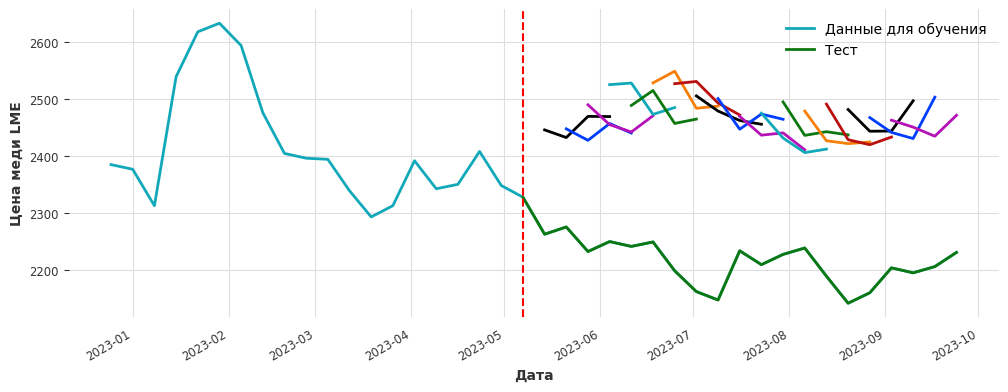

In [31]:
fig, ax = plt.subplots(figsize=(12, 4))
for key, value in out_of_time_prediction_curves.items():
    value.plot(label=None)
data_ts[-2*OUT_OF_TIME_DIM:].plot(label='Данные для обучения')
data_ts[-OUT_OF_TIME_DIM-1:].plot(label='Тест')
ax.set_ylabel('Цена меди LME');
ax.set_xlabel('Дата');
l1 = ax.axvline(x=ts.end_time(), color='r', linestyle='--', linewidth=1.5)
#plt.savefig('pic3.png', dpi=400, format='png')

In [ ]:
# Бэктест

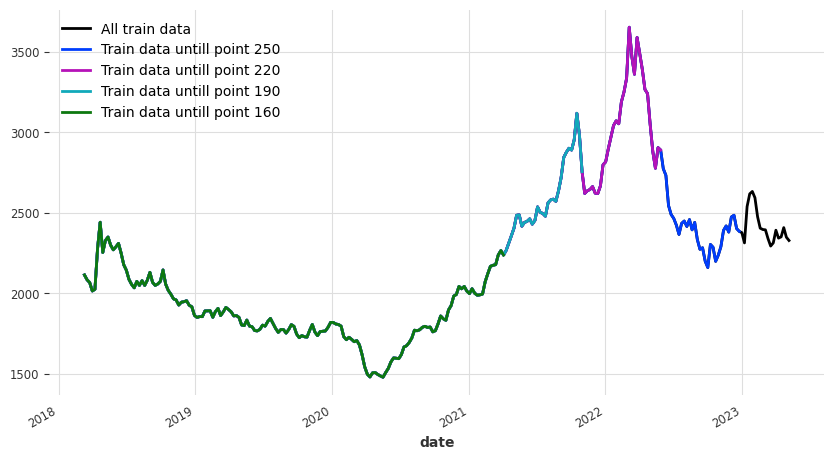

In [24]:
plt.figure(figsize=(10,5))
ts.plot(label='All train data')
for i in range(250, 149, -30):
    ts[:i+1].plot(label='Train data untill point '+str(i))

In [25]:
cbr_backtest = CatBoostModel(**model_settings,
                    output_chunk_length=FORECAST_LEN,
                    eval_metric = "MAPE",
                    task_type = "CPU",
                    thread_count = 16,
                    random_state=42)

bt_mape_metrics, bt_mae_metrics, bt_prediction_curves = manual_backtest(model=cbr_backtest,
                                                           ts=ts,
                                                           past_covariates=past_cov,
                                                           forecast_horizont=FORECAST_LEN,
                                                           start_test=160,
                                                           step = 30,
                                                           save_curves=True,
                                                           rolling_window=False,
                                                           window_size=None)

print("MAPE: {:.2f} +- {:.2f}".format(np.mean(bt_mape_metrics), np.std(bt_mape_metrics)))
print("MAPE: {:.2f} +- {:.2f}".format(np.mean(bt_mae_metrics), np.std(bt_mae_metrics)))

Iter # 1
Iter # 2
Iter # 3
Iter # 4
MAPE: 5.48 +- 4.58
MAPE: 122.62 +- 86.07


In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
for key, value in bt_prediction_curves.items():
    value.plot(label=None);
    ax.axvline(x=value.start_time() - datetime.timedelta(1), color='black', linestyle='--', linewidth=0.5)
ts[100:].plot(color='blue', label=None)
l1 = ax.axvline(x=ts.end_time(), color='r', linestyle='--', linewidth=1.5)
ax.set_ylabel('Цена меди LME');
ax.set_xlabel('Дата');
#plt.savefig('pic22.png', dpi=400, format='png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


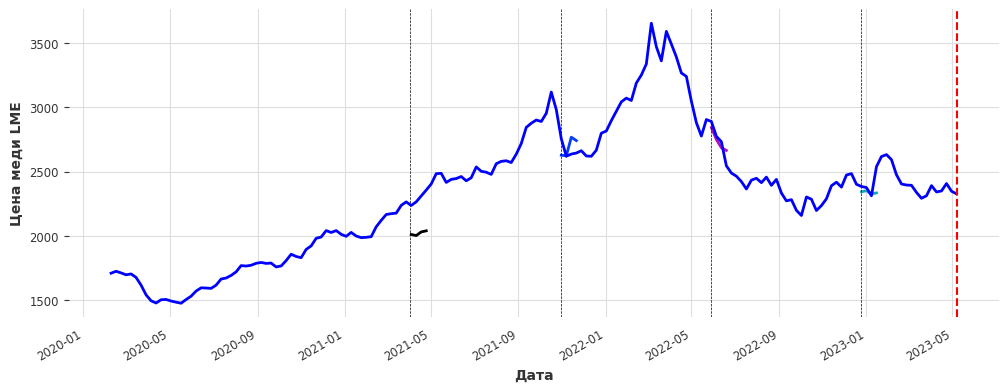

In [32]:
fig, ax = plt.subplots(figsize=(12, 4))
for key, value in pred_ts.items():
    value.plot(label=None);
    ax.axvline(x=value.start_time() - datetime.timedelta(1), color='black', linestyle='--', linewidth=0.5)
ts[100:].plot(color='blue', label=None)
l1 = ax.axvline(x=ts.end_time(), color='r', linestyle='--', linewidth=1.5)
ax.set_ylabel('Цена меди LME');
ax.set_xlabel('Дата');
#plt.savefig('pic22.png', dpi=400, format='png')

In [ ]:
#Train

In [33]:
start_point = 0
train_mape_metrics = list()
train_mae_metrics = list()
step = 5
while True:
    cur_test_input = ts[start_point : start_point + shift]
    past_cov_test_input = past_cov[start_point : start_point + shift]

    prediction = cbr.predict(series=cur_test_input,
                             past_covariates=past_cov_test_input,
                             n=int(FORECAST_LEN))

    mape_metric = mape(prediction, ts, intersect=True)
    mae_metric = mae(prediction, ts, intersect=True)
    train_mape_metrics.append(mape_metric)
    train_mae_metrics.append(mae_metric)
    
    start_point+=step
    if start_point + shift + int(FORECAST_LEN) > len(ts):
        break
                
print("MAPE: {:.2f} +- {:.2f}".format(np.mean(train_mape_metrics), np.std(train_mape_metrics)))
print("MAPE: {:.2f} +- {:.2f}".format(np.mean(train_mae_metrics), np.std(train_mae_metrics)))

MAPE: 0.93 +- 0.48
MAPE: 20.60 +- 13.42


In [34]:
metrics_dict = {
    "train_mean_mape":np.mean(train_mape_metrics),
    "train_std_mape":np.std(train_mape_metrics),
    "backtest_mean_mape":np.mean(bt_mape_metrics),
    "backtest_std_mape":np.std(bt_mape_metrics),
    "test_mean_mape_no_reffit":np.mean(mape_out_of_time_metrics_no_refit),
    "test_std_mape_no_reffit":np.std(mape_out_of_time_metrics_no_refit),
    "train_mean_mae":np.mean(train_mae_metrics),
    "train_std_mae":np.std(train_mae_metrics),
    "backtest_mean_mae":np.mean(bt_mae_metrics),
    "backtest_std_mae":np.std(bt_mae_metrics),
    "test_mean_mae_no_reffit":np.mean(mae_out_of_time_metrics_no_refit),
    "test_std_mae_no_reffit":np.std(mae_out_of_time_metrics_no_refit),
}

In [36]:
for i,v in metrics_dict.items():
    metrics_dict[i] = np.round(v, 2)

In [37]:
metrics_dict

{'train_mean_mape': 0.93,
 'train_std_mape': 0.48,
 'backtest_mean_mape': 5.48,
 'backtest_std_mape': 4.58,
 'test_mean_mape_no_reffit': 10.37,
 'test_std_mape_no_reffit': 1.44,
 'train_mean_mae': 20.6,
 'train_std_mae': 13.42,
 'backtest_mean_mae': 122.62,
 'backtest_std_mae': 86.07,
 'test_mean_mae_no_reffit': 256.05,
 'test_std_mae_no_reffit': 37.26}